In [109]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
import matplotlib as mpl
import matplotlib.pylab as pylab
from cycler import cycler
import palettable
from astropy.cosmology import Planck15
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.misc import derivative
from scipy.optimize import minimize
from scipy.special import erfc
from classy import Class

sys.path.append('/Users/smsharma/heptools/colossus/')

from colossus.cosmology import cosmology
from colossus.lss import mass_function

from theory.spec_calc import PowerSpectra, PowerSpectraPopulations
from theory.astrometry_forecast import Parameter, AstrometryObservation, FisherForecast
from theory.kink import MassFunctionKink, Sigma
from theory.units import *

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
params = {'text.usetex': True,
          'font.family': 'serif',
          'font.serif': ['CMU Serif'],
          'font.sans-serif': ['CMU Sans Serif'],
          'legend.fontsize': 17,
          'legend.fancybox': True,
          'legend.frameon': False,
          'legend.framealpha': 0.4,
          'legend.labelspacing': 0.5,
          'figure.figsize': (6.4/1.1, 4.8/1.1),
          'axes.labelsize': 19,
          'axes.titlesize':18,
          'axes.titlepad':10,
          'axes.linewidth':1.1,
          'axes.labelpad':10,
          'axes.prop_cycle': cycler('color', palettable.cartocolors.qualitative.Bold_10.hex_colors) + 
                            cycler(alpha=10*[.7]), 
          'lines.linewidth':2.5,
          'xtick.labelsize':18,
          'ytick.labelsize':18,
          'xtick.top':True,
          'ytick.right':True,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'xtick.major.size': 5,
          'xtick.minor.size': 2,
          'ytick.major.size': 5,
          'ytick.minor.size': 2,
          'xtick.major.width': 1,
          'ytick.major.width': 1,
          'xtick.minor.width': 0.8,
          'ytick.minor.width': 0.8,
         }
pylab.rcParams.update(params)

# Kinky

## Generate `CLASS` instances with kinked spectra

In [174]:
mfk = MassFunctionKink()

n_B = 2
k_B = 1

In [175]:
CLASS_inst = mfk.get_CLASS_kink(k_B=k_B,n_B=n_B, k_max=1e2)
CLASS_inst_vanilla = mfk.get_CLASS_kink(k_B=k_B, n_B=0.9665, k_max=1e2)

for idnx, inst in enumerate([CLASS_inst_vanilla, CLASS_inst]):
    k_ary = np.logspace(-6, np.log10(1e2), 10000)
    Pk_ary = np.array([inst.pk_lin(k,0) for k in k_ary])

    log10_k_interp_ary = np.linspace(-6, 7, 10000)
    log10_P_interp = interp1d(np.log10(k_ary * h), np.log10(Pk_ary / h ** 3), bounds_error=False, fill_value='extrapolate')
    log10_P_interp_ary = (log10_P_interp)(log10_k_interp_ary)
    
    if idnx == 1: filename = 'pk.dat'
    else: filename = 'pk_base.dat'
        
    np.savetxt("/Users/smsharma/PycharmProjects/Lensing-PowerSpectra/theory/arrays/" + filename, np.transpose([log10_k_interp_ary, log10_P_interp_ary]),
               delimiter='\t')

## Mass functions from `colossus`

In [176]:
cosmo = cosmology.setCosmology('planck18')

M_ary = np.logspace(5,12)

dndlnM_vanilla_ary = mass_function.massFunction(M_ary, 0.0, mdef = '200m', model = 'tinker08', q_in='M', q_out = 'dndlnM', ps_args={'model': mfk.randomword(5), 'path':"/Users/smsharma/PycharmProjects/Lensing-PowerSpectra/theory/arrays/pk_base.dat"})
dndlnM_ary = mass_function.massFunction(M_ary, 0.0, mdef = '200m', model = 'tinker08', q_in='M', q_out = 'dndlnM', ps_args={'model': mfk.randomword(5), 'path':"/Users/smsharma/PycharmProjects/Lensing-PowerSpectra/theory/arrays/pk.dat"})

dndlnM_vanilla_interp = interp1d(np.log10(M_ary * M_s), np.log10(dndlnM_vanilla_ary / M_ary))
dndlnM_interp = interp1d(np.log10(M_ary * M_s), np.log10(dndlnM_ary / M_ary))



In [177]:
N_calib = 150.

pref = N_calib / quad(lambda M: 10 ** dndlnM_vanilla_interp(np.log10(M)), 1e8 * M_s, 1e10 * M_s, epsabs=0, epsrel=1e-4)[0]
N_calib_new = pref * quad(lambda M: 10 ** dndlnM_interp(np.log10(M)), 1e8 * M_s, 1e10 * M_s, epsabs=0, epsrel=1e-4)[0]

In [178]:
N_calib_new

342.1171350239445

## Densities

In [179]:
sig = Sigma(log10_P_interp)

In [180]:
M_ary = np.logspace(6, 13, 10) * M_s
c200_ary = [sig.c200_zcoll(M)[0] for M in tqdm(M_ary)]










  0%|          | 0/10 [00:00<?, ?it/s]








 10%|█         | 1/10 [00:01<00:13,  1.45s/it]








 20%|██        | 2/10 [00:02<00:11,  1.41s/it]








 30%|███       | 3/10 [00:04<00:10,  1.44s/it]








 40%|████      | 4/10 [00:06<00:09,  1.58s/it]








 50%|█████     | 5/10 [00:08<00:08,  1.66s/it]








 60%|██████    | 6/10 [00:10<00:07,  1.75s/it]








 70%|███████   | 7/10 [00:11<00:05,  1.72s/it]








 80%|████████  | 8/10 [00:13<00:03,  1.81s/it]








 90%|█████████ | 9/10 [00:15<00:01,  1.79s/it]








100%|██████████| 10/10 [00:16<00:00,  1.66s/it]

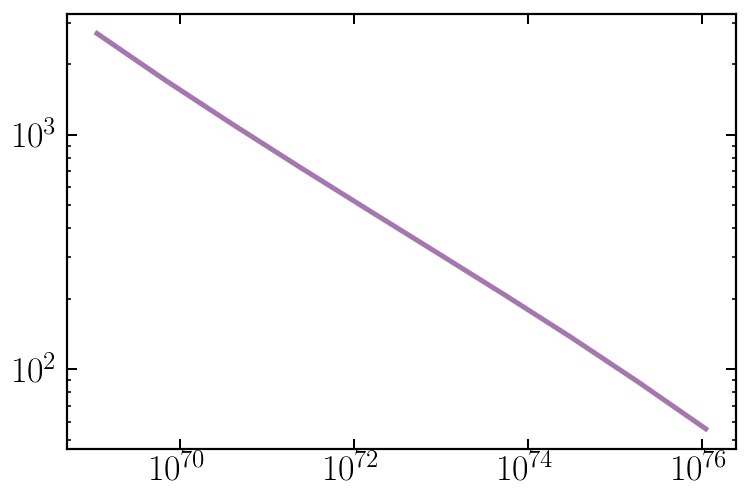

In [181]:
plt.plot(M_ary, c200_ary)
plt.xscale("log")
plt.yscale("log")

In [113]:
c200_interp = interp1d(np.log10(M_ary), np.log10(c200_ary))

In [114]:
def dndM(M):
    return 10 ** dndlnM_interp(np.log10(M))
 
def c200_custom(M):
    return 10 ** c200_interp(np.log10(M))


In [119]:
# pspecpop = PowerSpectraPopulations(l_max=2000)

# pspecpop.set_radial_distribution(pspecpop.r2rho_V_NFW, R_min=1e-2*kpc, R_max=260*kpc)
# pspecpop.set_mass_distribution(dndM, M_min=1e6*M_s, M_max=0.01*1.1e12*M_s,
#                                M_min_calib=1e8*M_s, M_max_calib=1e10*M_s, N_calib=N_calib_new)
# pspecpop.set_subhalo_properties(c200_custom)

# C_l_mu_new = pspecpop.get_C_l_total_ary()


(1e-12, 0.0001)

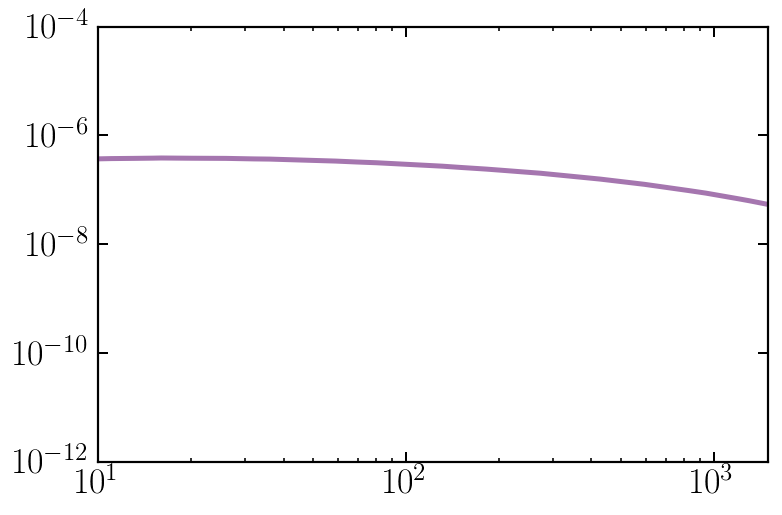

In [118]:
l_ary = np.arange(1, 2000)
plt.plot(l_ary, (1/(2*np.pi))*l_ary*(l_ary + 1)*C_l_mu_new)
plt.xscale("log")
plt.yscale("log")

plt.xlim(10, 1500)
plt.ylim(1e-12,1e-4)

## Analyze cluster runs

In [ ]:
def get_sens(Cl_ary, sigma_mu=1., N_q=1e8):

    fDM_base = 1
    dfDM_base = 0.1

    Cl_ary_fid = Cl_ary*fDM_base

    p = Cl_ary*(fDM_base + dfDM_base)
    m = Cl_ary*(fDM_base - dfDM_base)

    fDM = Parameter('fDM', fDM_base ,dfDM_base ,None, True, p, m, 
                    None, None, '$\\f_\mathrm{DM}$' )

    parameters = [Cl_ary_fid, None, 1, 2000, fDM]
    observation = AstrometryObservation(fsky=1, sigma_mu=sigma_mu, sigma_alpha=None, N_q_mu=N_q, l_min_mu=10, l_max_mu=2000, l_min_alpha=2, l_max_alpha=2000)

    fshr = FisherForecast(parameters, observation)
    lim = 1.64*np.sqrt(np.linalg.inv(fshr.fshr_cls + fshr.fshr_prior)[0,0])
    baseline_sig = fDM_base/fshr.pars_vary[0].sigma
    return lim, baseline_sig

In [ ]:
n_B_ary = (np.linspace(1, 6, 11))
k_B_ary = np.logspace(np.log10(1), np.log10(100), 11)

sens_ary = np.zeros((len(n_B_ary), len(k_B_ary)))

for i_n_B, n_B in enumerate(tqdm(n_B_ary)):
    for i_k_B, k_B in enumerate(k_B_ary):
        Cl_ary = np.load("../cluster/cluster_out/" + str(k_B) + "_" + str(n_B) + ".npz")['C_l_mu_new']
        sens_ary[i_n_B, i_k_B] = get_sens(Cl_ary)[1]

In [ ]:
mpl.rcParams['figure.figsize'] = 7, 5.5

levels = [1,3,5]
X, Y = np.meshgrid(np.log10(k_B_ary), n_B_ary)

fig, ax = plt.subplots()

CS = ax.contour(X, Y, sens_ary, levels = levels, linestyles=['-.','--','-'], colors='k', linewidths=2, alpha=0.7)

fmt = {}
strs = ['1$\sigma$', '3$\sigma$', '5$\sigma$']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
    
im = ax.imshow(sens_ary,cmap = 'PuBu', aspect='auto', origin='lower', extent=[0,2,1,6], vmin=0, vmax=10)

ax.clabel(CS, fmt=fmt,inline=1, fontsize=14)

ax.set_xlabel("$\log_{10}(k_B\,\mathrm{[Mpc^{-1}]})$")
ax.set_ylabel("$n_B$")
ax.set_title('\\textbf{Kinked power spectrum}', fontsize=18)

cbar = fig.colorbar(im)
cbar.set_label('Detection significance [$\sigma$]')

plt.tight_layout()
# plt.savefig(plots_dir + "LCDM_disc.pdf")